# Data exploration

In [1]:
!pip3 install scikit-learn==1 -U # degrade scikit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd

#### Load the data

In [3]:
nameF = 'features_sim121_0NL.csv'
df = pd.read_csv(nameF)
df.shape

(10000, 169)

In [4]:
nameT = 'targets_sim121_from0NL_to100NL.csv'
dt = pd.read_csv(nameT)
dt.shape

(10000, 14)

#### The columns in the data frame are (in Python indexes): <br>
**Features**<br>
0-59 ----- SRO (0-11) + MRO (12-59) <br>
60-159 --- Symmetry Functions <br>
160-168 -- Rotation Features <br>

**Targets: Displacements**<br>
1-4 -- Average global non-affine displacements - dx, dy, dz, dist <br>
5 ----- Average local non-affine displacements <br>
6 --- Outlier one big <br>
7 --- Outlier all big (round based on threshold)
(Binary label: 1=outlier, 0=not outlier) <br>
8-11 -- Standard deviation global non-affine displacements - dx, dy, dz, distm <br>
12 ---- Standard deviation local non-affine displacements <br>
13-14 - Standard deviation Outlier




#### Select the data

In [5]:
# select the SRO/MRO features for particles of just type 1
# X = df.iloc[0:8000,0:60]

# generate random features just to check for base performance
#X = pd.DataFrame(np.random.randint(0,100,size=(8000, 60)))

# select the symmetry function features for particles of just type 1
X = df.iloc[0:8000,0:60]

# SRO/MRO and symmetry functions
# X = df.iloc[0:8000,np.r_[0:160, 160:163]]

In [6]:
# select the targets

threshold = 0.5 # above this number it is considered an outlier
y_cont = dt.iloc[0:8000,6]
y = (y_cont >= threshold).astype(int)
y.value_counts()

0    7854
1     146
Name: avg_out_allBig, dtype: int64

#### Plot the correlation coefficients

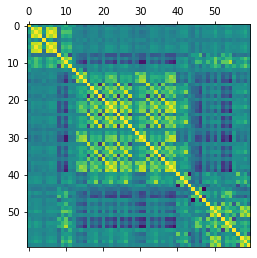

In [7]:
# If want the matrix with actual values
#corr = X.corr()
#corr.style.background_gradient(cmap='viridis',axis=None).format(precision=2)

import matplotlib.pyplot as plt
plt.matshow(X.corr())
plt.show()

In [26]:
# Get the correlation matrix - with values
rs = np.random.RandomState(0)
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm')

,SRO 1,SRO 2,SRO 3,SRO 4,SRO 5,SRO 6,SRO 7,SRO 8,SRO 9,SRO10,SRO11,SRO12,MRO 1,MRO 2,MRO 3,MRO 4,MRO 5,MRO 6,MRO 7,MRO 8,MRO 9,MRO10,MRO11,MRO12,MRO13,MRO14,MRO15,MRO16,MRO17,MRO18,MRO19,MRO20,MRO21,MRO22,MRO23,MRO24,MRO25,MRO26,MRO27,MRO28,MRO29,MRO30,MRO31,MRO32,MRO33,MRO34,MRO35,MRO36,MRO37,MRO38,MRO39,MRO40,MRO41,MRO42,MRO43,MRO44,MRO45,MRO46,MRO47,MRO48
SRO 1,1.000000,0.077454,0.272684,-0.031160,0.179940,0.093306,0.277202,0.013287,0.085776,0.192628,0.349311,0.123905,0.186972,-0.066370,-0.011753,-0.188916,0.023015,-0.047163,0.016405,-0.094222,0.040671,-0.040113,-0.020136,-0.102565,0.015021,-0.023382,0.019445,-0.073150,-0.054549,-0.037860,-0.163274,-0.126328,0.013777,-0.007897,0.038606,-0.047599,0.016635,-0.050339,-0.084511,-0.128906,0.024789,0.083273,0.120901,0.003403,-0.012180,0.137263,0.070790,0.048269,0.099820,0.056232,0.151358,0.002624,0.115352,0.171257,0.210564,0.038802,0.064663,0.050415,0.118629,-0.006853
SRO 2,0.077454,1.000000,0.732828,0.921943,-0.002429,0.826201,0.685367,0.808978,-0.147395,0.303299,0.222159,0.308035,0.031638,0.043968,0.067169,-0.016553,-0.004656,0.077758,0.072755,-0.005235,0.001300,0.133669,0.110438,0.076380,-0.006491,0.119413,0.104086,0.046604,-0.049523,0.029352,0.000146,0.013799,-0.010690,0.129584,0.092861,0.060599,-0.004087,0.111931,0.066963,0.050886,0.024611,0.112510,0.116530,0.011727,-0.073716,0.062975,-0.058936,0.071570,0.034613,0.051924,0.126295,0.036131,-0.005121,0.101381,0.073905,0.049711,0.048681,0.102662,0.159803,0.053504
SRO 3,0.272684,0.732828,1.000000,0.807354,0.158151,0.832967,0.978752,0.838790,-0.113729,0.502669,0.483968,0.477492,0.050799,0.019456,-0.010767,-0.111580,-0.009564,0.032134,0.047851,-0.065092,-0.000224,0.080176,0.052504,-0.012977,-0.011642,0.076860,0.077393,-0.022128,-0.099437,0.004681,-0.129263,-0.092908,-0.024192,0.095767,0.075352,0.006219,-0.017916,0.062019,-0.022675,-0.052869,0.050431,0.143656,0.173790,-0.015006,-0.077314,0.140375,-0.020299,0.093750,0.104415,0.106674,0.238688,0.051086,0.059874,0.219793,0.203871,0.076353,0.111749,0.161075,0.261508,0.059518
SRO 4,-0.031160,0.921943,0.807354,1.000000,-0.039466,0.892189,0.746119,0.919233,-0.143824,0.349567,0.265984,0.342170,0.020813,0.015079,0.013749,-0.068772,0.009165,0.046625,0.052301,-0.048262,0.011555,0.096230,0.074908,0.025128,0.008817,0.081793,0.084748,-0.002436,-0.064315,-0.004455,-0.067737,-0.057993,-0.001184,0.096807,0.075643,0.019592,-0.005635,0.069237,0.010249,-0.012451,0.046458,0.110980,0.137335,-0.010986,-0.069584,0.091752,-0.039606,0.081801,0.073813,0.070936,0.177128,0.045592,0.031394,0.138583,0.125848,0.043593,0.070517,0.120288,0.193578,0.064050
SRO 5,0.179940,-0.002429,0.158151,-0.039466,1.000000,0.031436,0.219844,-0.154416,-0.052092,0.082133,0.055582,0.115657,-0.029856,0.066490,0.011240,0.071422,-0.054526,0.053171,0.010104,0.065392,-0.070866,0.051673,-0.001655,0.061611,-0.053658,0.071938,0.010408,0.064189,-0.010361,0.057805,0.057084,0.063198,-0.051765,0.056123,-0.013655,0.055421,-0.054743,0.062624,0.031910,0.067686,-0.037069,0.023008,-0.029561,0.031016,-0.008776,-0.024878,-0.022740,-0.020623,-0.037804,0.016503,-0.013004,0.009721,-0.060062,-0.005132,-0.043785,0.032555,-0.022784,0.026412,0.017916,0.006180
SRO 6,0.093306,0.826201,0.832967,0.892189,0.031436,1.000000,0.800338,0.902745,-0.136634,0.341716,0.291267,0.335992,0.035926,0.014837,0.027334,-0.069511,-0.004443,0.049248,0.047342,-0.040076,0.003544,0.098181,0.070486,0.029001,-0.009070,0.086953,0.074703,0.006131,-0.069902,0.005532,-0.062632,-0.042281,-0.011918,0.104328,0.072169,0.028010,-0.006727,0.075794,0.015557,-0.003248,0.036345,0.110765,0.127410,-0.008134,-0.078668,0.105493,-0.042210,0.089032,0.051250,0.069153,0.151041,0.039298,0.013066,0.149980,0.118410,0.061839,0.065215,0.112885,0.175765,0.050173
SRO 7,0.277202,0.685367,0.978752,0.746119,0.219844,0.800338,1.000000,0.803056,-0.181762,0.469370,0.371090,0.498721,0.045660,0.092157,0.104143,0.009933,-0.011425,0.096618,0.115100,-0.000860,0.007689,0.168169,0.160529,0.096343,-0.015663,0.155722,0.145634,0.

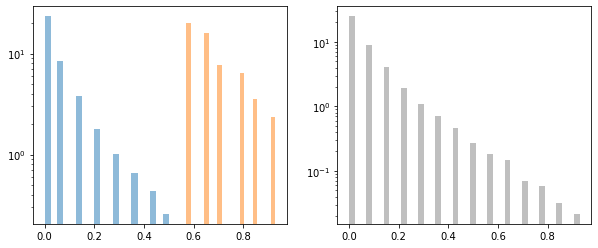

In [8]:
import matplotlib.pyplot as plt

# plot the histograms of the probability of being outliers

fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].hist(y_cont[(y_cont <= threshold)],  bins=20, density=True, alpha=0.5)
ax[0].hist(y_cont[(y_cont > threshold)],  bins=20, density=True, alpha=0.5)
ax[1].hist(y_cont,  bins=40, density=True, alpha=0.5, color='grey')

ax[0].set_yscale("log")#, nonpositive='clip')
ax[1].set_yscale("log")#, nonpositive='clip')


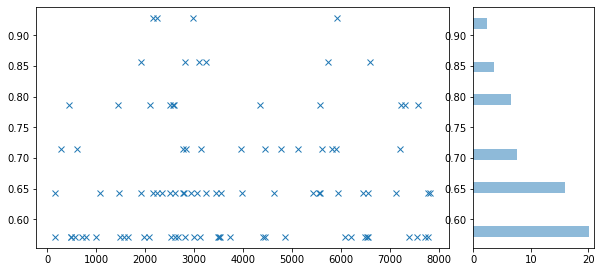

In [9]:
# check out: https://stackabuse.com/matplotlib-scatter-plot-with-distribution-plots-histograms-jointplot/

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 6))
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[1:4, 3])

ax_scatter.plot(y_cont[(y_cont > threshold)],marker="x", linewidth=0)

ax_hist_x.hist(y_cont[(y_cont > threshold)],  bins=20, density=True, alpha=0.5, orientation = 'horizontal')

plt.show()

# Split training/testing data

In [10]:
from sklearn.model_selection import train_test_split
from collections import Counter
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=42,stratify = y)
# split testing set 
print('Original dataset shape', Counter(y))
print('Training+Validation dataset shape', Counter(Y_train))
print('Testing dataset shape', Counter(Y_test))

Original dataset shape Counter({0: 7854, 1: 146})
Training+Validation dataset shape Counter({0: 6283, 1: 117})
Testing dataset shape Counter({0: 1571, 1: 29})


# Feature scaling

In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler=StandardScaler()
scaler.fit(X_train) 
X_train_scaled=scaler.transform(X_train)
X_test_scaled =scaler.transform(X_test)

# Resampling data: Easy Ensemble



ROC AUC train =0.998
ROC AUC test =0.726
Accuracy: 0.667
Precision: 0.035
Recall: 0.655
F-Measure: 0.067


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


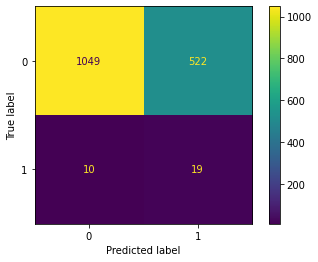

In [13]:
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, roc_auc_score

classifier = EasyEnsembleClassifier(base_estimator=GradientBoostingClassifier()) #base_estimator=GaussianNB()
classifier.fit(X_train_scaled, Y_train) #
ytrain_pred = classifier.predict(X_train_scaled) #
probs_train = classifier.predict_proba(X_train_scaled) #
# keep probabilities for the positive outcome only
probs_train = probs_train[:, 1]
# calculate scores
auc_train = roc_auc_score(Y_train, probs_train)
# summarize scores
print('ROC AUC train =%.3f' % (auc_train))

yhat = classifier.predict(X_test_scaled) #
probs = classifier.predict_proba(X_test_scaled) #
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate scores
auc = roc_auc_score(Y_test, probs)
# summarize scores
print('ROC AUC test =%.3f' % (auc))
# calculate roc curves
fpr, tpr, _ = roc_curve(Y_test, probs)
# evaluate predictions
print('Accuracy: %.3f' % accuracy_score(Y_test, yhat))
print('Precision: %.3f' % precision_score(Y_test, yhat))
print('Recall: %.3f' % recall_score(Y_test, yhat))
print('F-Measure: %.3f' % f1_score(Y_test, yhat))
plot_confusion_matrix(classifier, X_test_scaled, Y_test)  #
plt.show()

# Resampling data: Oversampling or Undersampling

Random Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(random_state=10)
X_ros, y_ros = ros.fit_resample(X, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 7826, 1: 174})
Resample dataset shape Counter({0: 7826, 1: 7826})


SMOTE methods

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from collections import Counter

#oversample = SMOTE()
#oversample = BorderlineSMOTE()
#oversample = SVMSMOTE()
#oversample = ADASYN()

X_ros, y_ros = oversample.fit_resample(X, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 7826, 1: 174})
Resample dataset shape Counter({0: 7826, 1: 5214})


# Model Training

#### Splint in training and testing

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=0)

#### Normalize features

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Initialize and train the model

In [ ]:
from sklearn.linear_model import LogisticRegression

# create an instance of the model
classifier = LogisticRegression(max_iter=1000)

# train the model
classifier.fit(X_train_scaled, y_train)

# predictions of the model
y_pred = classifier.predict(X_test_scaled)
# predict probabilities
yhat = classifier.predict_proba(X_test_scaled)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]

In [ ]:
# Train a dummy classifier
from sklearn.dummy import DummyClassifier

# no skill model, stratified random class predictions
model = DummyClassifier(strategy='stratified')
model.fit(X_train_scaled, y_train)
yhat_dummy = model.predict_proba(X_test_scaled)
pos_probs_dummy = yhat_dummy[:, 1]

# Model evaluation

Required variables:
- y_test
- y_pred
- pos_probs_dummy
- pos_probs

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# calculate roc auc
roc_auc = roc_auc_score(y_test, pos_probs_dummy)
print('No Skill ROC AUC %.3f' % roc_auc)
print('Classifier ROC AUC: %.3f' % roc_auc_score(y_test, pos_probs))

print('')

# evaluate predictions
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1-Measure: %.3f' % f1_score(y_test, y_pred))


No Skill ROC AUC 0.500
Classifier ROC AUC: 0.657

Accuracy: 0.614
Precision: 0.618
Recall: 0.607
F1-Measure: 0.612


**Confusion matrix**

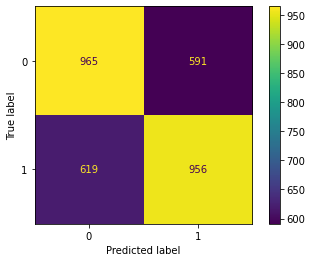

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

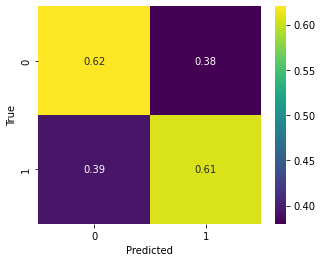

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap="viridis")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show(block=False)

#### ROC Curve

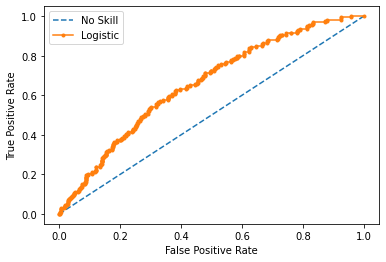

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot

# plot no skill roc curve
pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs)
# plot model roc curve
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot